# Camphor: SI Figure 9

## Defining Paths

In [1]:
from pathlib import Path
import nmrespy as ne

root = Path("../..")
molecule = "camphor"
data_path = root / "data" / molecule / "1"
output_dir = root / "code" / molecule / "output"

output_dir.mkdir(exist_ok=True, parents=True)

## Loading and Pre-processing the 2DJ Data

In [2]:
estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_path)
    estimator.phase_data(p0=5.238, p1=-6.262)
    estimator.baseline_correction()

## Estimation

In [3]:
import numpy as np

np.random.seed(0)

rerun_estimation = False
try:
    if rerun_estimation:
        raise ValueError("Re-running estimation.")
    estimator.get_results()
except ValueError:
    regions = [
        (2.35, 2.23),
        (2.09, 2.025),
        (1.95, 1.75),
        (1.7, 1.61),
        (1.375, 1.215),
    ]
    
    estimate_kwargs = dict(
        noise_region=(5.25, 5.21),
        region_unit="ppm",
        max_iterations=500,
        check_neg_amps_every=25,
    )
    for region in regions:
        estimator.estimate(region=region, **estimate_kwargs)
        estimator.to_pickle(estimator_path, force_overwrite=True)

## Plotting the Result

The threshold for determining multiplets has been increased to ensure it performs effectively.
It has been set to $2 f_{\text{sw}}^{(2)} / N^{(2)}$, i.e. double the spectral resoultion in the direct dimension.

In [4]:
import copy
import matplotlib.pyplot as plt

plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 7
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[:4]
colors.append("#808080")

mp_thold = 2.0 * estimator.default_multiplet_thold

default_plot_kwargs = dict(
    xaxis_ticks=[
        (0, [2.34, 2.32, 2.3, 2.28, 2.26, 2.24]),
        (1, [2.08, 2.06, 2.04]),
        (2, [1.94, 1.92, 1.9, 1.88, 1.86, 1.84, 1.82, 1.8, 1.78, 1.76]),
        (3, [1.68, 1.66, 1.64, 1.62]),
        (4, [1.36 - 0.02 * i for i in range(7)]),
    ],
    region_unit="ppm",
    multiplet_thold=mp_thold,
    multiplet_lw=0.8,
    marker_size=15.0,
    figsize=(12.0, 6.0),
    axes_left=0.05,
    axes_right=0.95,
    axes_bottom=0.1,
    axes_top=0.98,
    contour_base=1.0e4,
    contour_factor=1.5,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    ratio_1d_2d=(3.0, 1.0),
    clip_mp=2.0e5,
    clip_1d=4.0e5,
)

def make_colors(indices):
    return [colors[i] for i in indices]

def plot_result(estimator, **kwargs):
    plot_kwargs = copy.deepcopy(default_plot_kwargs)
    for key, value in kwargs.items():
        plot_kwargs[key] = value
    fig, axs = estimator.plot_result(**plot_kwargs)
   
    return fig, axs

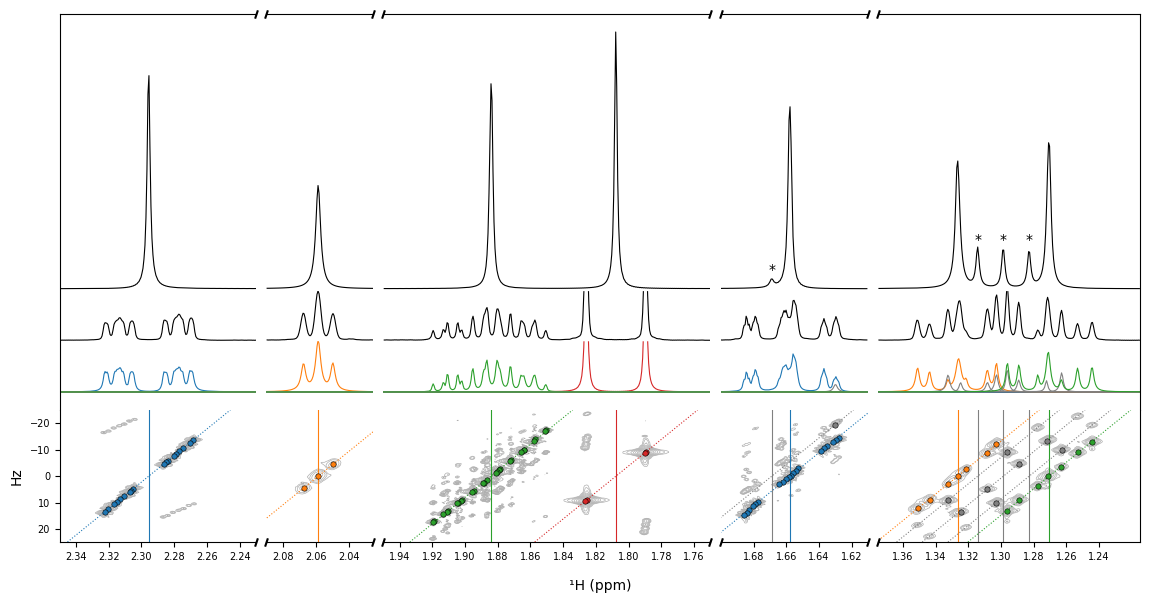

In [5]:
multiplet_colors = make_colors([0, 1, 2, 3, 4, 0, 1, 4, 4, 4, 2])
fig, axs = plot_result(estimator, multiplet_colors=multiplet_colors)

# Label stong coupling fetures in the CUPID spectrum.
axs[0, 3].text(1.669, 4.7e5, "*", ha="center")
axs[0, 4].text(1.314, 5.9e5, "*", ha="center")
axs[0, 4].text(1.299, 5.9e5, "*", ha="center")
axs[0, 4].text(1.283, 5.9e5, "*", ha="center");

## Strong Coupling Artifacts

Some strong coupling artifacts have been fit to the data, which have been coloured grey. Their impact on the pure shift spectrum is denoted with asterisks.

Let's call `predict_multiplets`, making sure to specify the threshold described above, with `rm_spurious=True` to see if any can be removed.

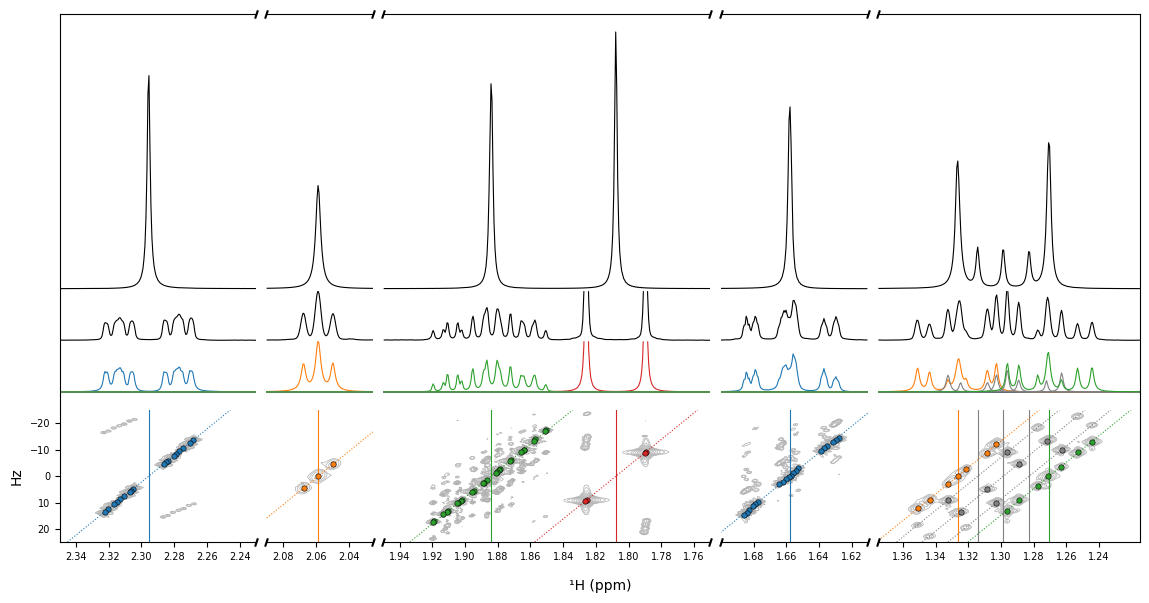

In [6]:
estimator.predict_multiplets(thold=mp_thold, rm_spurious=True)
multiplet_colors = make_colors([0, 1, 2, 3, 0, 1, 4, 4, 4, 2])
_, _ = plot_result(estimator, multiplet_colors=multiplet_colors)

Only one signal was removed (at ~1.63 ppm). The others, in the 1.34-1.26 ppm region were not removed, since they do not violate the first-order signal criteria. NMR-EsPy does not have any automated means to remove these as distinguishing them from true first-order signals is not strightforward.

### Manually Removing Persistent Strong Coupling Artifacts

If the user is confident about the presence of strong coupling artifacts, they can be manually removed. First it is necessary to identify the indices associated with the signals. The region of interest has index `4` (i.e. it was the 5th region considered). Calling `predict_multiplets`, with `indices=[4]` will give us the information needed.

In [7]:
multiplets = estimator.predict_multiplets(indices=[4], thold=mp_thold)
sfo = estimator.sfo[1]
for freq, indices in multiplets.items():
    print("{:.3f} ppm : {}".format(freq / sfo, indices))

1.271 ppm : [0, 1, 3, 4, 6, 7, 9]
1.283 ppm : [2, 11]
1.299 ppm : [5, 8, 13, 16]
1.314 ppm : [10, 18]
1.327 ppm : [12, 14, 15, 17, 19, 20, 21]


The signals of interest come from the multiplets centered about 1.283, 1.299, and 1.315 ppm. The indices of interest can be extracted as follows:

In [9]:
mp_indices = list(multiplets.values())
print("All indices: {}".format(mp_indices))
sc_indices = mp_indices[1:4]
print("Strong coupling indices: {}".format(sc_indices))
# merge the lists together
sc_indices = [item for sublist in sc_indices for item in sublist]
print("Merged: {}".format(sc_indices))

All indices: [[0, 1, 3, 4, 6, 7, 9], [2, 11], [5, 8, 13, 16], [10, 18], [12, 14, 15, 17, 19, 20, 21]]
Strong coupling indices: [[2, 11], [5, 8, 13, 16], [10, 18]]
Merged: [2, 11, 5, 8, 13, 16, 10, 18]


The signals can now be removed using `remove_oscillators()`. This method should be used sparingly and only when the user is confident that there are spurious/unwanted signals in the result. Its use should also be clearly documented.

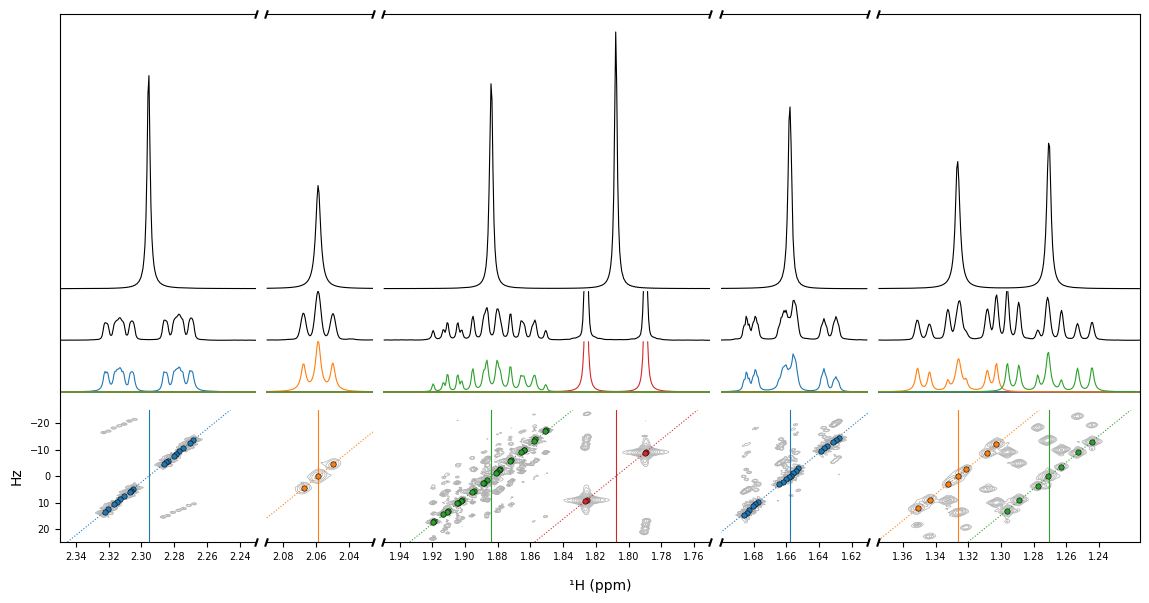

In [10]:
estimator.remove_oscillators(index=4, osc_indices=sc_indices)
multiplet_colors = make_colors([0, 1, 2, 3, 0, 1, 2])
_, _ = plot_result(estimator, multiplet_colors=multiplet_colors)